In [ ]:
# Install if needed for Kaggle or Google Colab
# !pip install -U bitsandbytes transformers accelerate

In [3]:
from huggingface_hub import login
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import matplotlib.pyplot as plt
import torch
import re
from sklearn.metrics import accuracy_score
import os


In [ ]:
# Login to HuggingFace from Kaggle
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)

In [6]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [16]:
model_id = 'google/gemma-2-9b-it'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

In [ ]:
qnli_test = pd.read_csv('/kaggle/input/qnli-val-csv/qnli_val.csv') # Make sure to change to csv location

qnli_test["label"] = qnli_test["label"].map({0: "entailment", 1: "not_entailment"})

In [14]:
qnli_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5463 non-null   object
 1   sentence  5463 non-null   object
 2   label     5463 non-null   object
 3   idx       5463 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 170.8+ KB


In [15]:
qnli_test.head()

,question,sentence,label,idx
0,What came into force after the new constitutio...,"As of that day, the new constitution heralding...",entailment,0
1,What is the first major city in the stream of ...,The most important tributaries in this area ar...,not_entailment,1
2,What is the minimum required if you want to te...,In most provinces a second Bachelor's Degree s...,not_entailment,2
3,How was Temüjin kept imprisoned by the Tayichi...,The Tayichi'ud enslaved Temüjin (reportedly wi...,entailment,3
4,"What did Herr Gott, dich loben wir become know...","He paraphrased the Te Deum as ""Herr Gott, dich...",not_entailment,4


In [16]:
# Find the max_length for tokenization to avoid wasting computing.
def get_lengths(df: pd.DataFrame) -> tuple:

    prompt_token_lengths = []
    label_token_lengths = []

    for _, row in df.iterrows():
        # Tokenize prompt
        prompt = f"Does the Sentence entail the Question? Answer exactly one word: 'not_entailment' or 'entailment'. \nQuestion: {row['question']} \nSentence: {row['sentence']} \nAnswer:"


        prompt_token = tokenizer(prompt)
        prompt_token_lengths.append(len(prompt_token["input_ids"]))


        # Tokenize label
        label_token = tokenizer(row["label"])
        label_token_lengths.append(len(label_token["input_ids"]))
    return prompt_token_lengths, label_token_lengths

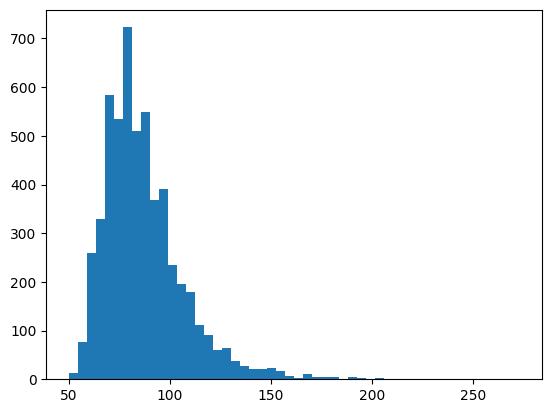

Max prompt length: 273
Max label length: 6


In [17]:
def find_max_length(df: pd.DataFrame) -> None:
    prompt_lengths, label_lengths = get_lengths(df)
    plt.hist(prompt_lengths, bins=50)
    plt.show()

    print("Max prompt length:", max(prompt_lengths))
    print("Max label length:", max(label_lengths))

find_max_length(qnli_test)

In [18]:
prompt_lengths, _ = get_lengths(qnli_test)
df = pd.DataFrame(prompt_lengths, columns=["length"])
print("Number of examples that have over 256 tokens:",(df["length"] > 256).sum())

Number of examples that have over 256 tokens: 1


Since we have only 1 example that goes over a length of 256, we are going to use 256 as the default for `max_length` and miss some information in order to offload computing.

In [19]:
class QNLIDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        premise = item['question']
        hypothesis = item['sentence']
        gold_label = item['label']

        # Format the prompt for decoder-only LLM
        prompt = f"Does the Sentence entail the Question? Answer exactly one word: 'not_entailment' or 'entailment'. \nQuestion: {premise} \nSentence: {hypothesis} \nAnswer:"

        # Tokenise prompt
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {"input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": gold_label}

Αν θέλετε να δείτε τα αποτελέσματα για ένα batch κάνετε uncomment το παρακάτω.

In [ ]:
# # Test run for one batch
# dataset_test = QNLIDataset(qnli_test, tokenizer)
# dataloader = DataLoader(dataset_test, batch_size=4, shuffle=False)

# batch_sample = next(iter(dataloader))
# input_ids = {k: v.to(model.device) for k, v in batch_sample.items() if k != "labels"}

# with torch.no_grad():
#     output = model.generate(**input_ids, max_new_tokens=20)

# out = tokenizer.batch_decode(output, skip_special_tokens=True)

# for text in out:
#     x = re.findall('[e|E]ntailment|[n|N]ot_entailment', text)
#     print(x[2])

In [ ]:
def extract_prediction(outputs_decoded, gold_labels, no_answer):
    predicted_labels = []
    for text, gold_label in zip(outputs_decoded, gold_labels):
            x = re.findall('[e|E]ntailment|[n|N]ot_entailment', text)
            try:
                predicted_labels.append(x[2].lower())
            except IndexError:
                no_answer += 1
                if gold_label == "not_entailment": # Comment below
                    predicted_labels.append("entailment")
                else:
                    predicted_labels.append("not_entailment")
    return predicted_labels

Στη προηγούμενη συνάρτηση τελικά μου φάνηκε ορθότερο να βάλω `no_answer` αντί για το αντίθετο όταν υπάρχει IndexError. Η ιδέα ήταν πως αν δεν έχει δώσει απάντηση, γιατί μου συνέβη καμιά φορά στις αρχές που τέσταρα, να βάλω ως απάντηση την αντίθετη από τη σωστή κλάση. Έτσι θα το έπαιρνε ως λάθος μετά στον υπολογισμό του accuracy. Στο mnli dataset όμως που έχει τρεις κλάσεις ήταν λίγο περίεργο πλέον και θεώρησα πως το `no_answer` θα έχει το ίδιο αποτέλεσμα. Το έχω αλλάξει στα καινούργια αλλά αυτό το έχω τρέξει έτσι και το έχω αφήσει να το δείτε. Δεν επηρέασε κάτι γιατί απάντησε σε όλα οπότε θα το αλλάξω αργότερα.

In [17]:
# Create checkpoint
checkpoint_path = f"checkpoint_{model_id.split('/')[1]}.pt".replace("-", "_"); checkpoint_path

'checkpoint_gemma_2_9b_it.pt'

In [ ]:
from tqdm import tqdm

dataset_test = QNLIDataset(qnli_test, tokenizer)
dataloader = DataLoader(dataset_test, batch_size=4, shuffle=False)

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    predicted_labels = checkpoint["predicted_labels"]
    gold_labels = checkpoint["gold_labels"]
    no_answer = checkpoint["no_answer"]
    start_batch = checkpoint['batch_no']
    print(f"Checkpoint found. Continuing from batch #{start_batch}.")
else:
    gold_labels, predicted_labels = [], []
    start_batch = 0
    no_answer = 0
    print("No checkpoint found.")

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):
        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        # Get outputs
        outputs = model.generate(input_ids=input_ids_batch, attention_mask=attention_mask_batch, max_new_tokens=6)
        outputs_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predicted_labels_batch = extract_prediction(outputs_decoded, gold_labels_batch, no_answer)
        predicted_labels.extend(predicted_labels_batch)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "no_answer": no_answer,
                        "batch_no": i+1}, checkpoint_path)
            
            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

In [18]:
checkpoint = torch.load(checkpoint_path)
predicted_labels = checkpoint["predicted_labels"]
gold_labels = checkpoint["gold_labels"]
no_answer = checkpoint["no_answer"]

In [19]:
# Calculate accuracy score
accuracy = accuracy_score(gold_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}\nNo Answer: {no_answer}")

Accuracy: 0.8514
No Answer: 0
